**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ sklearn 0.19.1

# Доверительные интервалы для оценки среднего

In [1]:
from sklearn import model_selection, datasets, linear_model, metrics

import numpy as np

In [2]:
import sklearn
print(np.__version__)
print(sklearn.__version__)

1.18.2
0.21.3


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [4]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

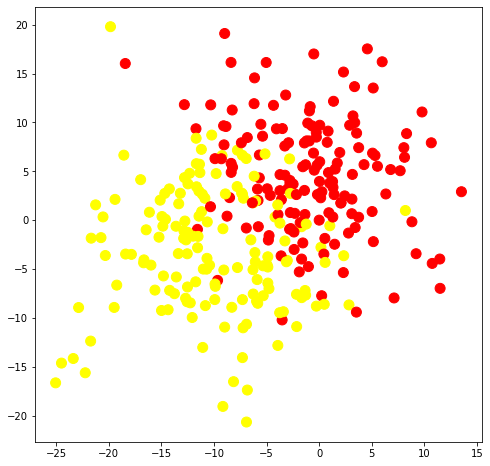

In [5]:
pylab.figure(figsize(8, 8))
pylab.scatter(list(map(lambda x: x[0], blobs[0])), list(map(lambda x: x[1], blobs[0])), c = blobs[1], cmap = 'autumn',
             s=100)

## Сравнение линейных моделей

### Точечная оценка

In [6]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(blobs[0], blobs[1], 
                                                                                    test_size = 15,
                                                                                    random_state = 1)

In [7]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

In [8]:
sgd_model = linear_model.SGDClassifier(random_state = 0, max_iter = 1000)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

0.7777777777777778

### Оценка среднего

In [9]:
sgd_auc_scores = model_selection.cross_val_score(linear_model.SGDClassifier(max_iter = 1000), 
                                 blobs[0], blobs[1], scoring = 'roc_auc', cv = 20)

In [10]:
ridge_auc_scores = model_selection.cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

### Точечная оценка среднего

In [11]:
print("sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print("ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.914, std 0.092
ridge model auc: mean 0.948, std 0.054


### Интервальная оценка среднего 

In [12]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

/Users/bs/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [14]:
print("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.6943738291415686, 1.1326350994298595)
ridge model mean auc 95%% confidence interval (0.728860436284426, 1.1671217065727166)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [15]:
type(sgd_auc_scores)

numpy.ndarray

In [16]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

In [17]:
print("sgd model mean auc 95%% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.8702452031844926, 0.9567637253869355)
ridge model mean auc 95%% confidence interval (0.9228783259302369, 0.9731038169269057)
